In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.data_processing import *
from utils.metrics import PRCurvePlotter
from sys import getsizeof
import matplotlib.pyplot as plt
import torch.nn.functional as F
from matplotlib import rcParams

# Generic Dataset and DataLoader and training a logistic regression

In [2]:
from torch import nn, optim
class LinearRegressor(nn.Module):
    def __init__(self, input_size=10, n_classes=2):
        super(LinearRegressor, self).__init__()

        self.linear = nn.Linear(input_size, n_classes)
        self.activation = nn.ReLU()

    def forward(self, x):
        out = self.activation(self.linear(x))
        

        return out    

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    """
    Characterizes a dataset for PyTorch
    """
    def __init__(self, feats, labels):
        'Initialization'
        self.labels = labels
        self.feats = feats

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.feats)

    def __getitem__(self, index):
        'Generates one sample of data'
        X = self.feats[index]
        y = self.labels[index]

        return X, y

In [4]:
# generating the data samples
class args:
    seed = 3

    
N,d = 100, 5
n_classes = 2
bias = -0.2
feats = np.random.randn(N,d) + bias
labels = np.array(0.5*(np.sign(np.sum(feats,axis=1)) + 1),dtype=int)


print(labels)
print(inv_weights(labels))

[0 0 0 0 1 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0 0]
[0.23 0.77]


In [5]:
from torch.utils.data.sampler import WeightedRandomSampler
batch_size = 10
shuffle = False
num_workers = 4


use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.manual_seed(args.seed)
    pin_memory = True
    # set flag for pinned memory on the data loader 
    print("using cuda")
else:    
    torch.manual_seed(args.seed)
    pin_memory = False
    
device = torch.device("cuda:0" if use_cuda else "cpu")


val_ratio = 0.1
tst_ratio = 0.2
val_size = int(len(feats)*(val_ratio))
tst_size = int(len(feats)*(tst_ratio))

trn_indx = (0,len(feats)-tst_size-val_size)
val_indx = (trn_indx[1],len(feats)-tst_size)
tst_indx = (val_indx[1],len(feats))


training_set = CustomDataset(feats[trn_indx[0]:trn_indx[1]],labels[trn_indx[0]:trn_indx[1]])
validation_set = CustomDataset(feats[val_indx[0]:val_indx[1]],labels[val_indx[0]:val_indx[1]])
testing_set = CustomDataset(feats[tst_indx[0]:tst_indx[1]],labels[tst_indx[0]:tst_indx[1]])

training_weights = map_to_weights(labels[trn_indx[0]:trn_indx[1]])
validation_weights = map_to_weights(labels[val_indx[0]:val_indx[1]])
testing_weights = map_to_weights(labels[tst_indx[0]:tst_indx[1]])

train_sampler = WeightedRandomSampler(weights=training_weights,
                                      num_samples=len(training_weights),
                                      replacement=False)
validation_sampler = WeightedRandomSampler(weights=validation_weights,
                                           num_samples=len(validation_weights),
                                           replacement=False)

testing_sampler = WeightedRandomSampler(weights=testing_weights,
                                        num_samples=len(testing_weights),
                                        replacement=False)


training_generator = DataLoader(dataset=training_set,
                                batch_size=batch_size,
                                shuffle=shuffle,
                                num_workers=num_workers,
                                pin_memory=pin_memory,
                                sampler=train_sampler)

validation_generator = DataLoader(dataset=validation_set,
                                batch_size=batch_size,
                                shuffle=shuffle,
                                num_workers=num_workers,
                                pin_memory=pin_memory,
                                sampler=validation_sampler)

testing_generator = DataLoader(dataset=testing_set,
                                batch_size=batch_size,
                                shuffle=shuffle,
                                num_workers=num_workers,
                                pin_memory=pin_memory,
                                sampler=testing_sampler)

### Note: use np.ravel_multi_index and np.unravel_index with get_item for datasets

In [6]:
# def __get_item__():
index = 34
t_size, x_size, y_size = 20, 5, 10
t,x,y = np.unravel_index(index, (t_size, x_size, y_size))
np.ravel_multi_index(multi_index=(t,x,y),dims=(t_size, x_size, y_size))

34

In [12]:
model = LinearRegressor(input_size=d,n_classes=n_classes)
model.to(device)

optimizer = optim.Adam(params=model.parameters(), lr=0.01, weight_decay=0.00)
# optimizer = optim.SGD(params=model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

# todo create class for this & add total losses
trn_loss = []
val_loss = []


# Loop over training data
for epoch in range(3):

    tmp_trn_loss = []
    # Training loop
    for local_batch, local_labels in training_generator:
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        out = model(local_batch.float())

        loss = loss_function(out, local_labels)
        tmp_trn_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    trn_loss.append(np.mean(tmp_trn_loss))    


    tmp_val_loss = []
    # Validation loop
    with torch.set_grad_enabled(False):
        # Transfer to GPU
        for local_batch, local_labels in validation_generator:
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)
            out = model(local_batch.float())

            loss = loss_function(out, local_labels)
            tmp_val_loss.append(loss.item())
    val_loss.append(np.mean(tmp_val_loss))

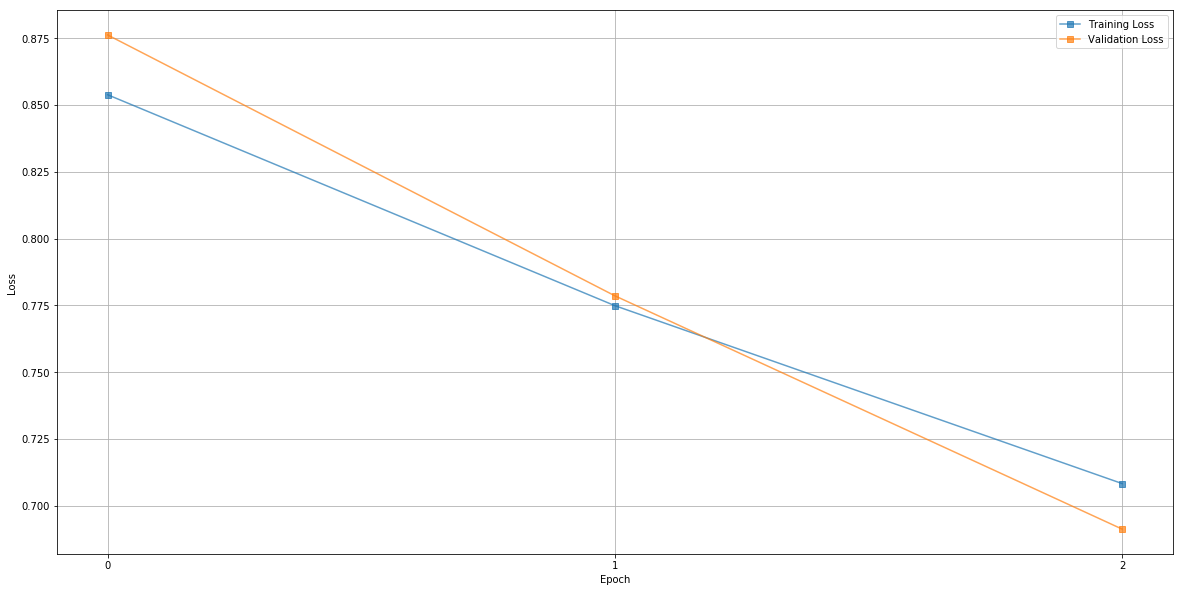

In [13]:
plt.figure(figsize=(20,10))
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.xticks(list(range(len(trn_loss))))

kwargs = {
         "marker":"s",
         "markersize":6,
         "alpha":0.7,    
}

plt.plot(trn_loss,label="Training Loss",**kwargs)
plt.plot(val_loss,label="Validation Loss",**kwargs)
plt.legend()
plt.grid()
plt.show()

In [14]:
# Evaluation on test set
# Validation
with torch.set_grad_enabled(False):
    # Transfer to GPU
    testing_losses = []
    y_true = []
    y_pred = []
    probas_pred = []
    for local_batch, local_labels in training_generator: # loop through is set does not fit in batch
        y_true.extend(local_labels.tolist())
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        out = model(local_batch.float())
        out = F.softmax(out,dim=1)
        out_label = torch.argmax(out,dim=1)
        y_pred.extend(out_label.tolist())
        out_proba = out[:,1] # likelihood of crime is more general form - when comparing to moving averages
        probas_pred.extend(out_proba.tolist())

In [27]:
from sklearn.metrics import accuracy_score, precision_recall_curve, average_precision_score, roc_curve, roc_auc_score

In [28]:
acc = accuracy_score(y_true,y_pred)
print(f"acc: {acc}")

acc: 0.5714285714285714


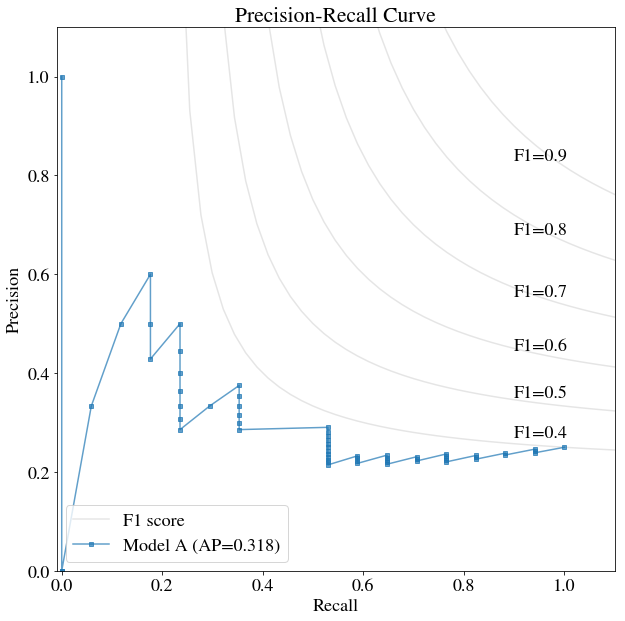

In [40]:
# todo make class for roc and auc plot
pr_plotter = PRCurvePlotter()
pr_plotter.add_curve(y_true, probas_pred, label_name="Model A")
pr_plotter.show()

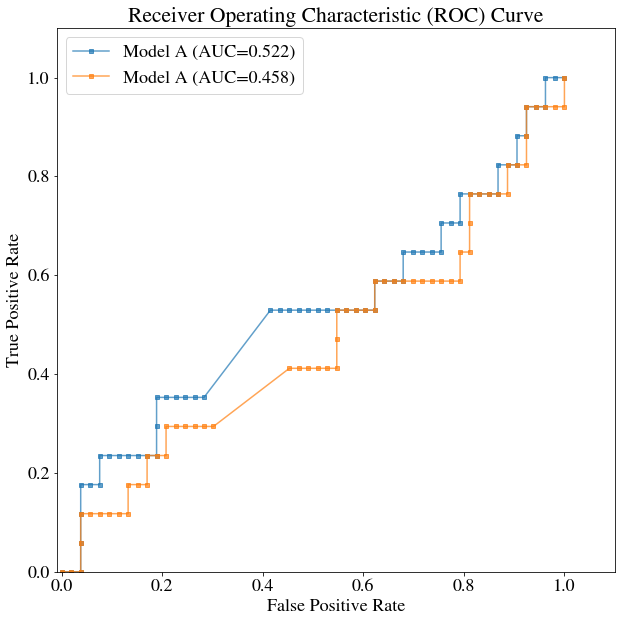

In [39]:
roc_plotter = ROCCurvePlotter()
roc_plotter.add_curve(y_true, probas_pred, label_name="Model A")
roc_plotter.add_curve(y_true, np.roll(probas_pred,10), label_name="Model A")
roc_plotter.show()

## Todo have AUC per fram over time 
Use `auc = roc_auc_score(y_true, y_score)`
